# Training a multiclass classifier on a seismogram dataset

In this notebook I intend to do some exploratory analysis on the dataset of the seismograms used in the earthquake location procedure.

# Exploration analysis
I will start with loading the dataset from the local folder, as well as loading some of the modules I plan to use:


In [163]:
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics,neighbors
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split,cross_val_score
from plotly.plotly import iplot,plot
import plotly.graph_objs as go
import plotly.tools as tls 
import pandas as pd
from LocationsOnGrid import LocationsOnGridSmall
import matplotlib as mpl
mpl.style.use('ggplot')
import plotly.tools as tls

# Load the observations and the location labels for a 60 Class Training + Test set.
Observations = np.genfromtxt("./Observations.csv",dtype = float,defaultfmt = "%.3e",delimiter = ',')
ObservationsPicks = np.genfromtxt("./ObservationsPicks.csv",dtype = float,defaultfmt = "%.3e",delimiter = ',')
ClassLabels  = np.genfromtxt("./ClassLabels.csv",dtype = float,defaultfmt = "%d",delimiter = ',')

Each observation is marked by a Class label - an integer value describing the location where EQ occurred and produced the corresponding ground motion recorded in the observation row. Let's make sure we're dealing with 60 classes (2x2x15)


In [92]:
print np.unique(ClassLabels)
print Observations.shape



[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.]
(9000, 768)
(58,)


Let's see what that looks like on the map. Let's load the locations of the source classes:

In [164]:
Sources = pd.read_csv('SourcesWithPicks.csv')

_,_,_,stCoords = LocationsOnGridSmall(receiver_name='receiver.dat',NX=1,NY = 1,NZ =1) # Get the receiver locations

PltlyMapLayout = go.Layout(width=600,height=600,hovermode='closest')
PltlySrc = go.Scatter3d(y=Sources.Y,x=Sources.X,z=-Sources.Z,mode = 'markers',text = Sources.Class,name = 'Sources',
                       marker=dict(
                       size='10',
                       color = Sources.Z,
                       colorscale='Portland',
                       showscale=False),
                       )       
PltlyStations = go.Scatter3d(y=stCoords[:,1],x=stCoords[:,0],z =stCoords[:,2] ,mode = 'markers',name = 'Stations',
                       marker=dict(
                       size='10',
                       color='black',
                       showscale=False),
                       )
                       
data = [PltlySrc,PltlyStations]
pltlyfig = go.Figure(data=data,layout = PltlyMapLayout)
url0 = plot(pltlyfig,name='3dscat')
tls.embed(url0)




The noise has been introduced in the model by randomly perturbing the reference time of the seismogram. In reality it will correspond to an uncertainty in the origin time of the event due to mispicking the arrivals. However, the real waveforms are usually contaminated by the noise too. Therefore, as a first order approximation we can superimpose some Gaussian noise on the observations:

In [78]:
# Perturb the observations with the noise:
sigma = 0.02
mu=0
Observations = Observations + (sigma * np.random.randn(Observations.shape[0],Observations.shape[1]) + mu)


Let's now take a look at the observations:

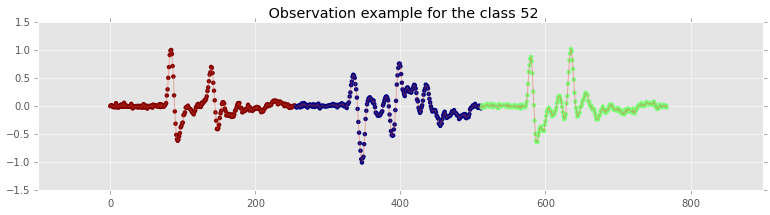

In [79]:
plt.figure(figsize=(13,3))
nsample=256
ind_example = np.random.randint(low=0,high = Observations.shape[0])
obs_example = Observations[ind_example,:]
point_colors = np.hstack((np.repeat(4,nsample),np.repeat(2,nsample),np.repeat(3,nsample)))
plt.scatter(x =np.array(range(nsample*3)), y=obs_example,c=point_colors,edgecolors="none")
plt.plot(obs_example,alpha=0.4)
title = " Observation example for the class %d" % ClassLabels[ind_example]
plt.title(title)

# Classifier training: Logistic regression


Now we can move on to training the data using classifiers from sklearn package. First of all, we have to break down the dataset into the training and the test part. I chose a 70% - 30% split 

In [80]:
X_train, X_test, y_train, y_test = train_test_split(Observations, ClassLabels, test_size=0.3, random_state=123)
X_trainPicks, X_testPicks, y_trainPicks, y_testPicks = train_test_split(ObservationsPicks, ClassLabels, 
                                                                        test_size=0.3, random_state=123)


We can also briefly analyze standard deviations per feature:


(9000, 6)

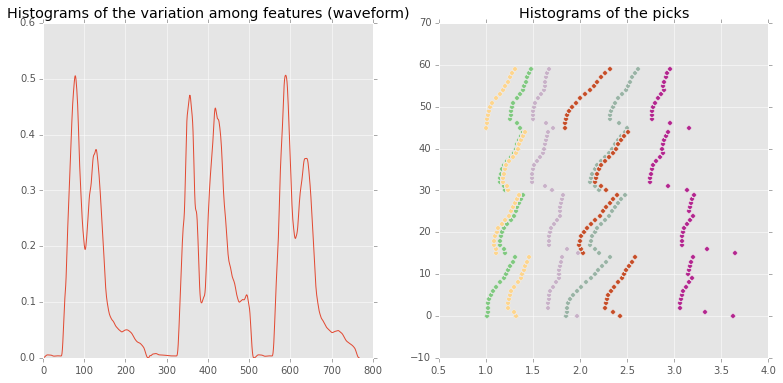

In [149]:
import matplotlib.cm as cm
norm1=mpl.colors.Normalize(vmin=0,vmax=ObservationsPicks.shape[1])
m = cm.ScalarMappable(norm=norm1, cmap=cm.Accent)
PicksDF = pd.DataFrame(data =ObservationsPicks[:,:],columns = ['Psta1', 'Ssta1',  'Psta2', 'Ssta2',  'Psta3',
       'Ssta3'])
PicksDF['Labels'] =  ClassLabels
groups = PicksDF.groupby(by='Labels')
fig,ax = plt.subplots(nrows=1,ncols =2,figsize = (13,6))
stdWf = np.apply_along_axis(np.std, 0, Observations)
stdPicks = np.apply_along_axis(np.histogram,0,ObservationsPicks)
ax[0].plot(stdWf)
ax[0].set_title('Histograms of the variation among features (waveform)')


for i in range(ObservationsPicks.shape[1]):
    ax[1].scatter(ObservationsPicks[:,i],ClassLabels,label = str(i),c= m.to_rgba(i),s=20)
    
    
ax[1].set_title('Histograms of the picks')
#plt.legend()


This plot is indicative of where we see the information about the signal phases. 

The classifier I would like to start my fitting with is Logistic Regression. This classifier is relatively simple, and has only one parameter I can fiddle with - regularization constant C. For the first trial, I will initialize the regression with default values:

In [150]:
logreg = linear_model.LogisticRegression()


(6300, 6)

I fit this default classifier on the training data and test the performance on the test subset. The performance is for now assessed through accuracy metric. This choice is relatively evident since my classes are not skewed in any particular direction.

Now let's use the classifier to predict the classes in the test set:

In [161]:
EQ_default_params_fit = logreg.fit(X_trainPicks, y_trainPicks)

predicted = EQ_default_params_fit.predict(X_testPicks)
probs = EQ_default_params_fit.predict_proba(X_testPicks)
ConfMatrix  = metrics.confusion_matrix(y_testPicks,predicted)
ScoreMetric =  metrics.accuracy_score(y_testPicks, predicted)
print ScoreMetric,"\n"

PltlyMapLayout = go.Layout(width=600,height=600,hovermode='closest')
PltlyCM = go.Heatmap(z = ConfMatrix)
refline = go.Scatter(x=range(ConfMatrix.shape[0]),y=range(ConfMatrix.shape[0]),
                    marker=dict(
                       size='10',
                        opacity = 0.2,
                       color='black',
                       showscale=False),
                    )

                       
data = [PltlyCM,refline]
pltlyfig2 = go.Figure(data=data,layout = PltlyMapLayout)
url = plot(pltlyfig2,name='cm')
import plotly.tools as tls
tls.embed(url)


0.207777777778 

https://plot.ly/~Anton.Biryukov/36


In [155]:
print ConfMatrix[0:15,0:15]

[[28  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [45  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 47  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 41  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 38]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 43]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 40]]


Num of zero coefs = 367
Num of zero coefs = 343
Num of zero coefs = 305
Num of zero coefs = 369
Num of zero coefs = 376
Num of zero coefs = 338


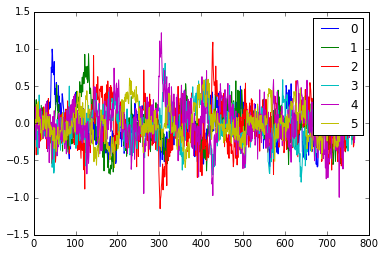

In [109]:
for i in range(EQ_default_params_fit.coef_.shape[0]):
    plt.plot(EQ_default_params_fit.coef_[i,:])
    #print "Num of zero coefs = %d" % (EQ_default_params_fit.coef_[i,:] == 0).sum()
plt.legend(range(EQ_default_params_fit.coef_.shape[0]))


">" 85% is not too bad with a null error rate of 1/6. Let's see if we can adjust the regularization parameter to achieve a better fit. 

# Grid search over the parameters (C)
A good start would be to run an exhaustive search over C values using gridsearch technique in sklearn.

In [151]:
from sklearn.grid_search import GridSearchCV
logreg = linear_model.LogisticRegression(penalty='l1')
params = {
    "C": np.logspace(0,6,20),
    "penalty":["l1"],
}
gs = GridSearchCV(logreg,params,cv=5,n_jobs=4)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e+00,   2.06914e+00,   4.28133e+00,   8.85867e+00,
         1.83298e+01,   3.79269e+01,   7.84760e+01,   1.62378e+02,
         3.35982e+02,   6.95193e+02,   1.43845e+03,   2.97635e+03,
         6.15848e+03,   1.27427e+04,   2.63665e+04,   5.45559e+04,
         1.12884e+05,   2.33572e+05,   4.83293e+05,   1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [143]:
print "Best Score is " , gs.best_score_ , " at the param C value of " , gs.best_params_


Best Score is  0.910714285714  at the param C value of  {'C': 335.98182862837808}


Now I can correct the estimator accordingly with C from gs.best_param

In [236]:

logreg = linear_model.LogisticRegression(C=gs.best_params_['C'],penalty='l1')
EQ_default_params_fit = logreg.fit(X_train, y_train)

predicted = EQ_default_params_fit.predict(X_test)
probs = EQ_default_params_fit.predict_proba(X_test)
ConfMatrix  = metrics.confusion_matrix(y_test,predicted)
ScoreMetric =  metrics.accuracy_score(y_test, predicted)
print ScoreMetric,"\n",ConfMatrix

0.886111111111 
[[62  1  1  1  1  0]
 [ 5 59  2  0  0  0]
 [ 0  2 43  2  2  0]
 [ 0  1  2 56  4  0]
 [ 0  1  7  1 46  4]
 [ 0  0  1  1  2 53]]


Let's take a look at the coefficients now:

Num of zero coefs = 562
Num of zero coefs = 551
Num of zero coefs = 514
Num of zero coefs = 551
Num of zero coefs = 532
Num of zero coefs = 560


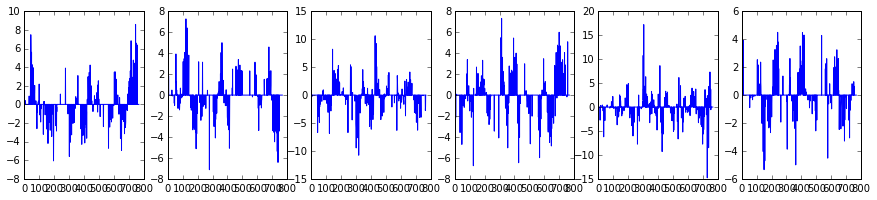

In [237]:
num_classes = EQ_default_params_fit.classes_.shape[0]
fig,ax =plt.subplots(1,num_classes)
fig.set_size_inches((15,3))

for i in range(num_classes):
    ax[i].plot(EQ_default_params_fit.coef_[i,:])
    print "Num of zero coefs = %d" % (EQ_default_params_fit.coef_[i,:] == 0).sum()


It can also be shown how the # of non-zero coefficients changes for a particular class as a function of regularization parameter C:

Num of zero coefs = 670 
Value of Creg = 1.000e+00
Score is 0.84
Num of zero coefs = 644 
Value of Creg = 4.642e+00
Score is 0.87
Num of zero coefs = 621 
Value of Creg = 2.154e+01
Score is 0.88
Num of zero coefs = 601 
Value of Creg = 1.000e+02
Score is 0.88
Num of zero coefs = 537 
Value of Creg = 4.642e+02
Score is 0.89
Num of zero coefs = 412 
Value of Creg = 2.154e+03
Score is 0.88
Num of zero coefs = 93 
Value of Creg = 1.000e+04
Score is 0.87
Num of zero coefs = 28 
Value of Creg = 4.642e+04
Score is 0.85
Num of zero coefs = 3 
Value of Creg = 2.154e+05
Score is 0.85
Num of zero coefs = 0 
Value of Creg = 1.000e+06
Score is 0.86


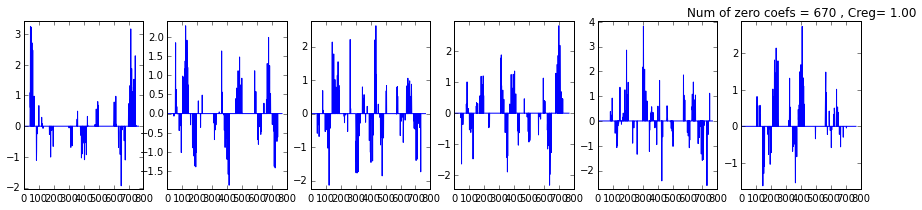

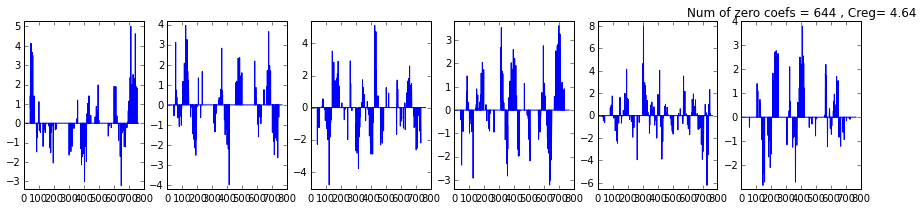

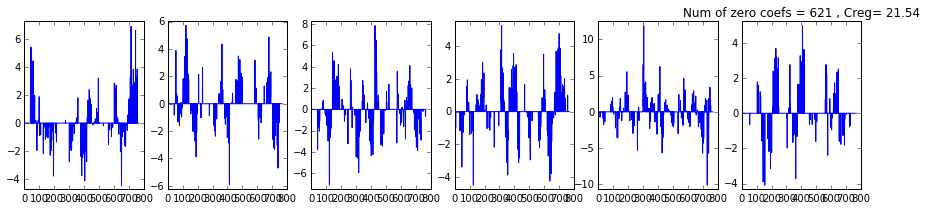

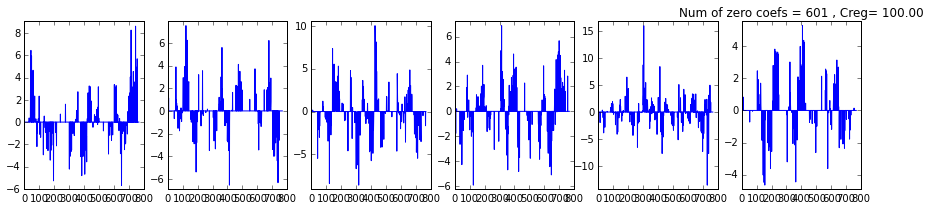

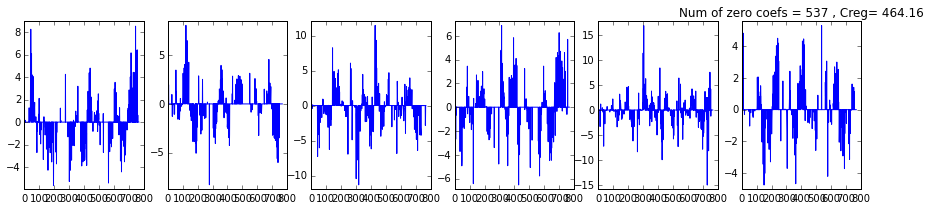

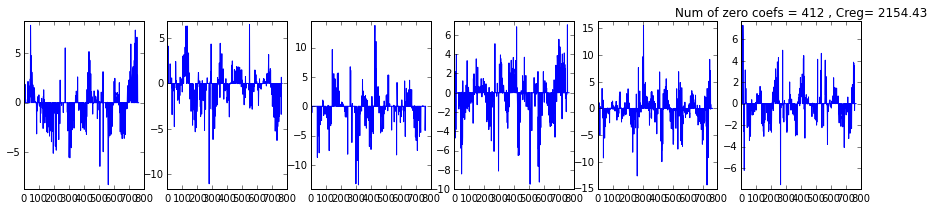

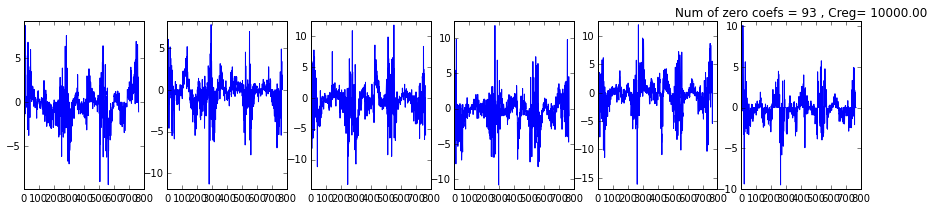

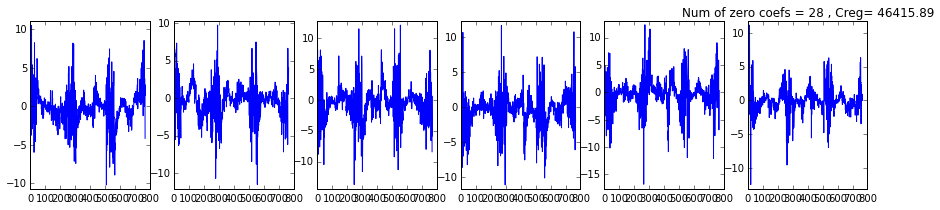

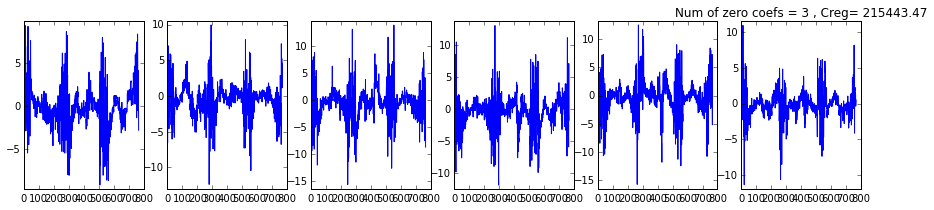

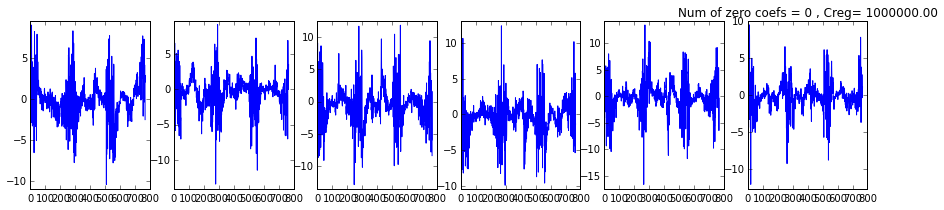

In [229]:
for CReg in np.logspace(0,6,10):
    logreg = linear_model.LogisticRegression(C=CReg,penalty='l1')
    EQ_default_params_fit = logreg.fit(X_train, y_train)
    predicted = EQ_default_params_fit.predict(X_test)
    probs = EQ_default_params_fit.predict_proba(X_test)
    ScoreMetric =  metrics.accuracy_score(y_test, predicted)
    print "Num of zero coefs = %d " % (EQ_default_params_fit.coef_[0,:] == 0).sum()
    print "Value of Creg = %3.3e" % CReg
    print "Score is %2.2f" % ScoreMetric
    num_classes = EQ_default_params_fit.classes_.shape[0]
    fig,ax =plt.subplots(1,num_classes)
    fig.set_size_inches((15,3))
    for j in range(num_classes):
        #ax[j].scatter(x =np.array(range(nsample*3)), y=EQ_default_params_fit.coef_[j,:],c=point_colors,
                      #edgecolors="none")
        ax[j].plot(EQ_default_params_fit.coef_[j,:])
        #ax[j].plot(x =range(0,nsample,1), y=EQ_default_params_fit.coef_[j,0:255],color='r')
        #x[j].plot(x =range(nsample,2*nsample,1),y=EQ_default_params_fit.coef_[j,256:511],color='b')
        #ax[j].plot(x =range(2*nsample,3*nsample,1),y=EQ_default_params_fit.coef_[j,512:767],color='g')

        plt.title("Num of zero coefs = %d , Creg= %2.2f" % ((EQ_default_params_fit.coef_[0,:] == 0).sum(),CReg))
        
        ax[j].set_ylim(1.05*np.min(EQ_default_params_fit.coef_[j,:]),1.05*np.max(EQ_default_params_fit.coef_[j,:]))
       



The coefficient values somewhat make sense: they indicate the time of the main arrivals of the signal and its phases at the stations. In fact, as the number of non-zero coefficients increases, the model becomes over sensitive to parts of the trace where no physical causal signal is present. 

Next step would be to analyze the principal components of the dataset and determine how the algorithm performs on the modified dataset:

Let's see how many zero coefficients are common for all the classes. It might be meaningful to actually cross-plot this number with the accuracy of the classifier at a given value of regression parameter C.

In [281]:
def null_column(x):
    if np.all(x == 0):
        return True
    else:
        return False
CommonZeros= np.apply_along_axis(null_column,0,EQ_default_params_fit.coef_)
print " Number of shared null coefficients : ", CommonZeros.sum()

 Number of shared null coefficients :  242


In [306]:
num_ofCregs = 20
Carray =  np.logspace(0,7,num_ofCregs)
ScoreCreg=np.zeros(num_ofCregs)
CommonZerosCreg=np.zeros(num_ofCregs)
i=0
for CReg in Carray :
    logreg = linear_model.LogisticRegression(C=CReg,penalty='l1')
    EQ_creg = logreg.fit(X_train, y_train)
    predicted = EQ_creg.predict(X_test)
    ScoreCreg[i] =  metrics.accuracy_score(y_test, predicted)
    #print ScoreCreg[i]
    CommonZerosCreg[i]= np.apply_along_axis(null_column,0,EQ_creg.coef_).sum()
    #print CommonZerosCreg[i]
    i+=1
print ScoreCreg
    

[ 0.83611111  0.86944444  0.86944444  0.875       0.88055556  0.88055556
  0.88888889  0.89166667  0.89166667  0.89166667  0.88055556  0.86388889
  0.86944444  0.86388889  0.85        0.85        0.85277778  0.84722222
  0.86666667  0.86111111]


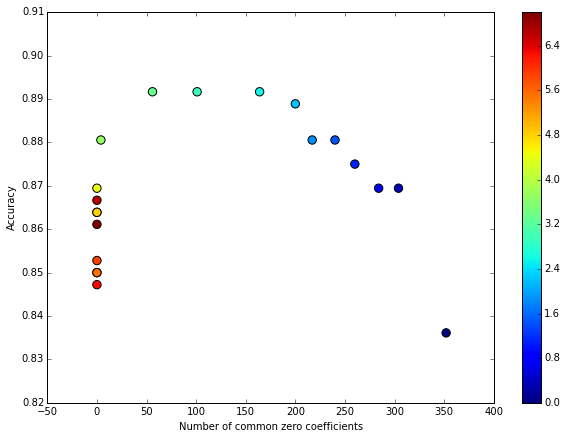

In [316]:
plt.figure(figsize = (10,7))
plt.scatter(y=ScoreCreg,x=CommonZerosCreg,c= np.log10(Carray),s =70)
plt.colorbar()
plt.xlabel("Number of common zero coefficients")
plt.ylabel("Accuracy")


# PCA Analysis
I will use the sklearn-supplied PCA analysis functions. BTW, with the size of my dataset and the number of features, this procedure is relatively cheap.

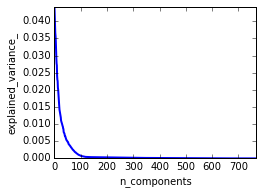

In [275]:
from sklearn import decomposition

pca_traces = decomposition.PCA()
pca_traces.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_traces.explained_variance_/pca_traces.explained_variance_.sum(), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [259]:
a = np.zeros((1,768))
a[0,400] = 1;
print EQ_default_params_fit.coef_[:,150]
b = pca_traces.transform(a)


[ 0.          0.          1.20268536  0.          1.11929257 -3.83400216]
